In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
from tqdm import tqdm
import torch

In [5]:
model = YOLO('../yolov8x.pt')

if torch.backends.mps.is_available():
    model.to("mps")

In [70]:
cap = cv2.VideoCapture("../data/raw/test_video.mov")

In [71]:
from time import time

fps = cap.get(cv2.CAP_PROP_FPS)

centers: list = []    # Bounding Boxes
image = None
CONF_THRESHOLD: float = 0.3
counter: int = 0
frame_count: int = 0
take_every_k_frame: int = fps

number_of_people_over_time = {}


while(cap.isOpened()):
    ret, frame = cap.read()
    # If no frame is available, break while loop
    if ret == False:
        break
    if image is None:
        image = frame

    # Take every 24th frame
    counter += 1
    if counter % take_every_k_frame != 0:
        continue
    
    # Transform BGR image to RGB image and predict on given frame
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = model.predict(frame, classes=[0], conf=CONF_THRESHOLD, verbose=False)
    for r in results:
        boxes = r.boxes
        for box in boxes:
            b = box.xyxy[0]     # Get box coordinates in (top, left, bottom, right) format
            c = box.cls     # Get Classification label
            conf = round(box.cpu().conf.numpy()[0], 2)    # Round confidence to 2 decimal places
            x0, y0, x1, y1 = b
            x, y, w, h = x0, y0, x1-x0, y1-y0
            center: tuple = (int(x + w/2), int(y1))     # Get shoe position (center)
            centers.append(center)

    # Check if 3 (or some other value) seconds passed
    for r in results:
        print(f"Number of people: {len(r.boxes)}")
        number_of_people_over_time[frame_count] = len(r.boxes)
        # Reset the time counter

    # Track how many frames were taken
    frame_count += 1

cap.release()
cv2.destroyAllWindows()

Number of people: 8
Number of people: 7
Number of people: 9
Number of people: 11
Number of people: 11
Number of people: 10
Number of people: 9
Number of people: 10
Number of people: 10
Number of people: 9
Number of people: 12
Number of people: 16
Number of people: 14
Number of people: 12
Number of people: 16
Number of people: 19
Number of people: 13
Number of people: 12
Number of people: 14
Number of people: 8
Number of people: 8
Number of people: 7
Number of people: 13
Number of people: 13
Number of people: 12
Number of people: 14
Number of people: 12
Number of people: 14
Number of people: 9
Number of people: 10
Number of people: 8
Number of people: 11
Number of people: 10
Number of people: 10
Number of people: 8
Number of people: 11
Number of people: 9
Number of people: 11
Number of people: 12
Number of people: 11
Number of people: 12
Number of people: 11
Number of people: 12
Number of people: 14


In [72]:
number_of_people_over_time


{0: 8,
 1: 7,
 2: 9,
 3: 11,
 4: 11,
 5: 10,
 6: 9,
 7: 10,
 8: 10,
 9: 9,
 10: 12,
 11: 16,
 12: 14,
 13: 12,
 14: 16,
 15: 19,
 16: 13,
 17: 12,
 18: 14,
 19: 8,
 20: 8,
 21: 7,
 22: 13,
 23: 13,
 24: 12,
 25: 14,
 26: 12,
 27: 14,
 28: 9,
 29: 10,
 30: 8,
 31: 11,
 32: 10,
 33: 10,
 34: 8,
 35: 11,
 36: 9,
 37: 11,
 38: 12,
 39: 11,
 40: 12,
 41: 11,
 42: 12,
 43: 14}

In [78]:
list(number_of_people_over_time.keys())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43]

In [84]:
number_of_people_over_time.values()

dict_values([8, 7, 9, 11, 11, 10, 9, 10, 10, 9, 12, 16, 14, 12, 16, 19, 13, 12, 14, 8, 8, 7, 13, 13, 12, 14, 12, 14, 9, 10, 8, 11, 10, 10, 8, 11, 9, 11, 12, 11, 12, 11, 12, 14])

TypeError: Axes.bar() missing 1 required positional argument: 'height'

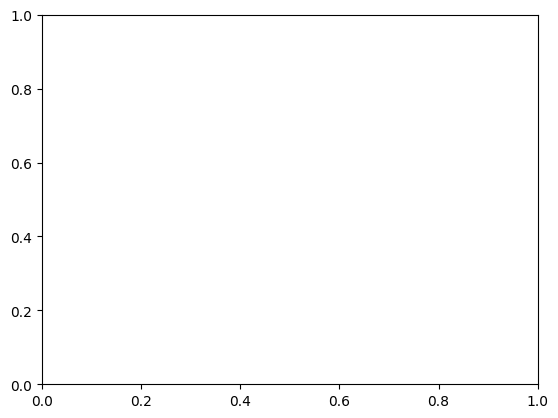

In [87]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.bar(number_of_people_over_time.values)

ax.set_ylabel('fruit supply')
ax.set_title('Fruit supply by kind and color')
ax.legend(title='Fruit color')

plt.show()

In [14]:
densities = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
for center in tqdm(centers):
    size = (30, 30)
    angle = 0
    startAngle = 0
    endAngle = 360
    density = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
    cv2.ellipse(density, center, size, angle, startAngle, endAngle, (1, 1), -1)
    densities = densities + density
# Postprocess densities / heatmap
densities = cv2.GaussianBlur(densities, (21, 21), 0)
densities = cv2.normalize(densities, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
heatmap = cv2.applyColorMap(densities, cv2.COLORMAP_TURBO)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
img = cv2.addWeighted(image, 0.5, heatmap, 1, 0)

100%|██████████| 9609/9609 [00:29<00:00, 323.71it/s]


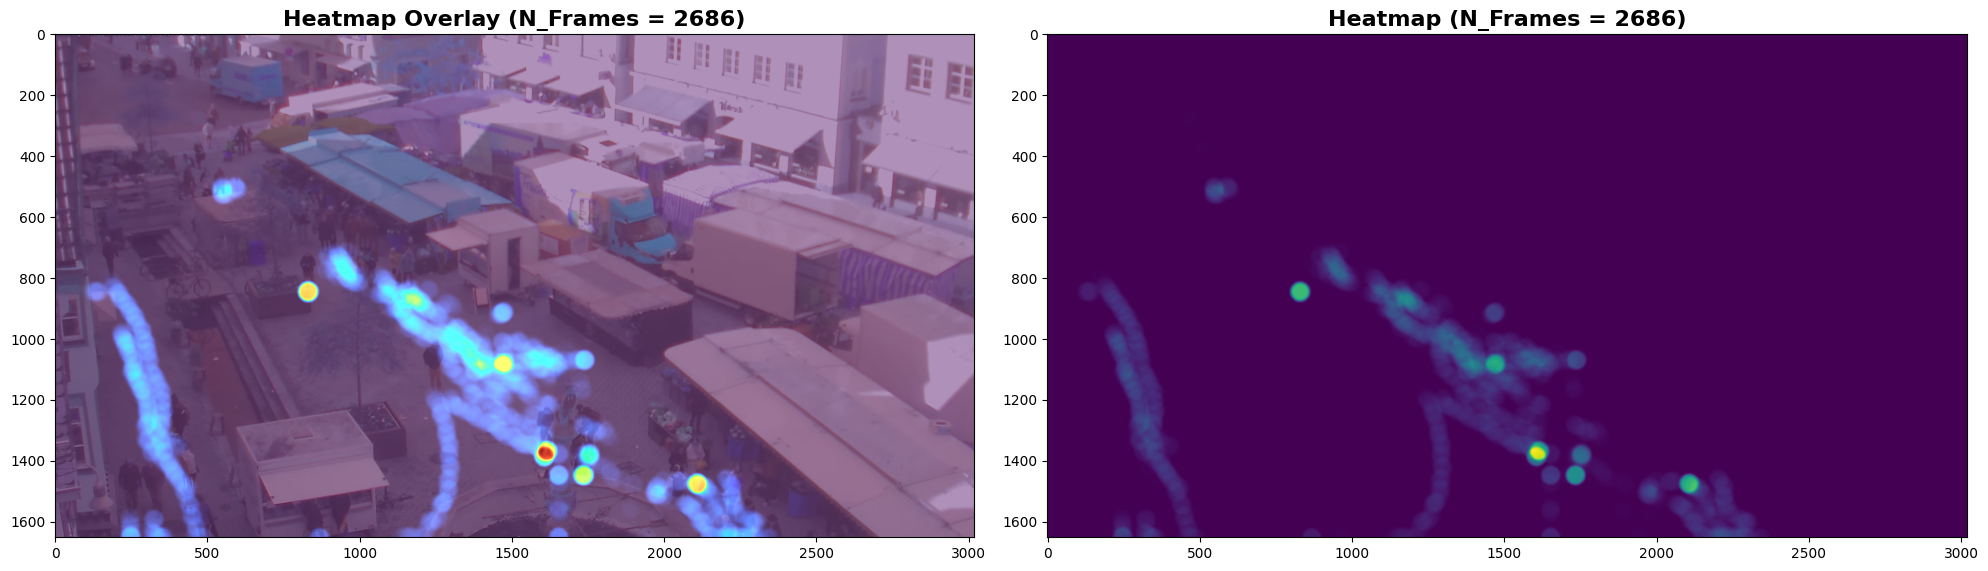

In [20]:
def plot_densities(img: np.array, densities: np.array, frame_count: int) -> None:
    """ Plots the densities / heatmap as a two axis plot
    First axis shows the heatmap overlayed on the first input image;
    Second axis show the heatmap only.

    :param img: np.array -- Image with heatmap overlay (Result of cv2.addWeighted(image, heatmap))
    :param densities: np.array -- Image of heatmap
    :return: None
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    axes[0].imshow(img)
    axes[0].set_title(f"Heatmap Overlay (N_Frames = {frame_count})", size=16, fontweight="bold")
    axes[1].imshow(densities)
    axes[1].set_title(f"Heatmap (N_Frames = {frame_count})", size=16, fontweight="bold")
    fig.tight_layout()
    #plt.savefig("../assets/heatmap.png", dpi=126, bbox_inches='tight')
    plt.show()

plot_densities(img, densities, frame_count)